<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/task1_federato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install -q flwr["simulation"] tensorflow
!pip install -q flwr_datasets["vision"]
!pip install matplotlib

from typing import Dict, List, Tuple
import tensorflow as tf
import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from datasets import Dataset
from flwr_datasets import FederatedDataset
from keras.initializers import RandomNormal, he_normal, glorot_normal, he_uniform, glorot_uniform

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# Simulation parameters
settings = {
    "VERBOSE": 0,
    "NUM_CLIENTS": 100,
    "FRACTION_FIT": 0.1,
    "FRACTION_EVALUATE": 0.05,
    "MIN_FIT_CLIENTS": 10,
    "MIN_EVALUATE_CLIENTS": 5,
    "MIN_AVAILABLE_CLIENTS_FRACTION": 0.75,
    "STRATEGY_TYPE": 'FedOptim', # FedOptim, FedAvg, FedProx
    "NUM_ROUNDS": 10
}

In [54]:
import tensorflow as tf
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten
!pip install tensorflow-addons
from tensorflow_addons.metrics import F1Score

def get_model():
    """Constructs a model suitable for features."""
    # Define input layers
    Support_Calls_input = Input(shape=(1,), name='Support Calls')
    Payment_Delay_input = Input(shape=(1,), name='Payment Delay')
    Usage_Frequency_input = Input(shape=(1,), name='Usage Frequency')
    Total_Spend_input = Input(shape=(1,), name='Total Spend')
    Last_Interaction_input = Input(shape=(1,), name='Last Interaction')
    Age_18_25_input = Input(shape=(1,), name='Age_binned_(18.0, 25.0]')
    Age_25_35_input = Input(shape=(1,), name='Age_binned_(25.0, 35.0]')
    Age_35_50_input = Input(shape=(1,), name='Age_binned_(35.0, 50.0]')
    Age_50_60_input = Input(shape=(1,), name='Age_binned_(50.0, 60.0]')
    Age_60_70_input = Input(shape=(1,), name='Age_binned_(60.0, 70.0]')
    Age_nan_input = Input(shape=(1,), name='Age_binned_nan')
    Contract_Length_Annual_input = Input(shape=(1,), name='Contract Length_Annual')
    Contract_Length_Monthly_input = Input(shape=(1,), name='Contract Length_Monthly')
    Contract_Length_Quarterly_input = Input(shape=(1,), name='Contract Length_Quarterly')
    Contract_Length_nan_input = Input(shape=(1,), name='Contract Length_nan')
    Gender_Female_input = Input(shape=(1,), name='Gender_Female')
    Gender_Male_input = Input(shape=(1,), name='Gender_Male')
    Gender_nan_input = Input(shape=(1,), name='Gender_nan')
    Subscription_Type_Basic_input = Input(shape=(1,), name='Subscription Type_Basic')
    Subscription_Type_Premium_input = Input(shape=(1,), name='Subscription Type_Premium')
    Subscription_Type_Standard_input = Input(shape=(1,), name='Subscription Type_Standard')
    Subscription_Type_nan_input = Input(shape=(1,), name='Subscription Type_nan')

    # Concatenate the input tensors
    concatenated_inputs = concatenate([
        Support_Calls_input, Payment_Delay_input, Usage_Frequency_input, Total_Spend_input, Last_Interaction_input,
        Age_18_25_input, Age_25_35_input, Age_35_50_input, Age_50_60_input, Age_60_70_input, Age_nan_input,
        Contract_Length_Annual_input, Contract_Length_Monthly_input, Contract_Length_Quarterly_input, Contract_Length_nan_input,
        Gender_Female_input, Gender_Male_input, Gender_nan_input,
        Subscription_Type_Basic_input, Subscription_Type_Premium_input, Subscription_Type_Standard_input, Subscription_Type_nan_input
    ])

    # Define the rest of the model
    x = Flatten()(concatenated_inputs)
    x = Dense(80, activation="PReLU", kernel_initializer=he_normal())(x)
    x = Dense(64, activation="relu", kernel_initializer=he_normal())(x)
    x = Dense(16, activation="tanh", kernel_initializer=he_normal())(x)
    x = Dense(32, activation="sigmoid", kernel_initializer=glorot_normal())(x)
    output = Dense(1, activation="sigmoid", kernel_initializer=glorot_normal())(x)

    # Construct the model
    model = tf.keras.models.Model(inputs=[
        Support_Calls_input, Payment_Delay_input, Usage_Frequency_input, Total_Spend_input, Last_Interaction_input,
        Age_18_25_input, Age_25_35_input, Age_35_50_input, Age_50_60_input, Age_60_70_input, Age_nan_input,
        Contract_Length_Annual_input, Contract_Length_Monthly_input, Contract_Length_Quarterly_input, Contract_Length_nan_input,
        Gender_Female_input, Gender_Male_input, Gender_nan_input,
        Subscription_Type_Basic_input, Subscription_Type_Premium_input, Subscription_Type_Standard_input, Subscription_Type_nan_input
    ], outputs=output)

    # Compile the model with accuracy, precision, recall, and F1-score metrics
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model


In [55]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, valset) -> None:
        # Create model
        self.model = get_model()
        self.trainset = trainset
        self.valset = valset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=settings['VERBOSE'])
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        results = self.model.evaluate(self.valset)

        loss = results[0]
        accuracy = results[1]
        precision = results[2]
        recall = results[3]


        return loss, len(self.valset), {"accuracy": accuracy, "precision":precision, "recall":recall}

In [56]:
# Download MNIST dataset and partition it
mnist_fds = FederatedDataset(dataset="giulioappetito/churn_dataset_giulioappetito", partitioners={"train": settings['NUM_CLIENTS']})
# Get the whole test set for centralised evaluation
centralized_testset = mnist_fds.load_full("test").to_tf_dataset(
  columns=[
            'Support Calls',
            'Payment Delay',
            'Usage Frequency',
            'Total Spend',
            'Last Interaction',
            'Age_binned_(18.0, 25.0]',
            'Age_binned_(25.0, 35.0]',
            'Age_binned_(35.0, 50.0]',
            'Age_binned_(50.0, 60.0]',
            'Age_binned_(60.0, 70.0]',
            'Age_binned_nan',
            'Contract Length_Annual',
            'Contract Length_Monthly',
            'Contract Length_Quarterly',
            'Contract Length_nan',
            'Gender_Female',
            'Gender_Male',
            'Gender_nan',
            'Subscription Type_Basic',
            'Subscription Type_Premium',
            'Subscription Type_Standard',
            'Subscription Type_nan'
        ],
        label_cols="Churn", batch_size=64
    )

/usr/local/lib/python3.10/dist-packages/flwr_datasets/utils.py:84: UserWarning: The currently tested dataset are ['mnist', 'cifar10', 'fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet']. Given: giulioappetito/churn_dataset_giulioappetito.
  warnings.warn(


In [57]:
# @title
def get_client_fn(dataset: FederatedDataset):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)
        trainset = client_dataset_splits["train"].to_tf_dataset(
            columns=[
                'Support Calls',
                'Payment Delay',
                'Usage Frequency',
                'Total Spend',
                'Last Interaction',
                'Age_binned_(18.0, 25.0]',
                'Age_binned_(25.0, 35.0]',
                'Age_binned_(35.0, 50.0]',
                'Age_binned_(50.0, 60.0]',
                'Age_binned_(60.0, 70.0]',
                'Age_binned_nan',
                'Contract Length_Annual',
                'Contract Length_Monthly',
                'Contract Length_Quarterly',
                'Contract Length_nan',
                'Gender_Female',
                'Gender_Male',
                'Gender_nan',
                'Subscription Type_Basic',
                'Subscription Type_Premium',
                'Subscription Type_Standard',
                'Subscription Type_nan'
            ],
            label_cols="Churn", batch_size=32
        )
        valset = client_dataset_splits["test"].to_tf_dataset(
            columns=[
                'Support Calls',
                'Payment Delay',
                'Usage Frequency',
                'Total Spend',
                'Last Interaction',
                'Age_binned_(18.0, 25.0]',
                'Age_binned_(25.0, 35.0]',
                'Age_binned_(35.0, 50.0]',
                'Age_binned_(50.0, 60.0]',
                'Age_binned_(60.0, 70.0]',
                'Age_binned_nan',
                'Contract Length_Annual',
                'Contract Length_Monthly',
                'Contract Length_Quarterly',
                'Contract Length_nan',
                'Gender_Female',
                'Gender_Male',
                'Gender_nan',
                'Subscription Type_Basic',
                'Subscription Type_Premium',
                'Subscription Type_Standard',
                'Subscription Type_nan'
            ],
            label_cols="Churn", batch_size=64
        )

        # Create and return client
        return FlowerClient(trainset, valset).to_client()

    return client_fn


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    precisions = [num_examples * m["precision"] for num_examples, m in metrics]
    recalls = [num_examples * m["recall"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples), "precision":sum(precisions) / sum(examples),"recall":sum(recalls) / sum(examples)}


def get_evaluate_fn(testset: Dataset):
    """Return an evaluation function for server-side (i.e. centralised) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        results = model.evaluate(testset)
        loss = results[0]
        return loss, {"accuracy": results[1], "precision":results[2], "recall":results[3]}

    return evaluate


In [60]:
# Create FedAvg strategy
strategy_FedOptim = fl.server.strategy.FedProx(
    proximal_mu=1.0,
    fraction_fit=settings["FRACTION_FIT"],
    fraction_evaluate=settings["FRACTION_EVALUATE"],
    min_fit_clients=settings["MIN_FIT_CLIENTS"],
    min_evaluate_clients=settings["MIN_EVALUATE_CLIENTS"],
    min_available_clients=int(settings["NUM_CLIENTS"] * settings["MIN_AVAILABLE_CLIENTS_FRACTION"]),
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=get_evaluate_fn(centralized_testset),
)

strategy_FedProx = fl.server.strategy.FedProx(
    proximal_mu=1.0,
    fraction_fit=settings["FRACTION_FIT"],
    fraction_evaluate=settings["FRACTION_EVALUATE"],
    min_fit_clients=settings["MIN_FIT_CLIENTS"],
    min_evaluate_clients=settings["MIN_EVALUATE_CLIENTS"],
    min_available_clients=int(settings["NUM_CLIENTS"] * settings["MIN_AVAILABLE_CLIENTS_FRACTION"]),
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=get_evaluate_fn(centralized_testset),
)

strategy_FedAvg = fl.server.strategy.FedAvg(
    fraction_fit=settings["FRACTION_FIT"],
    fraction_evaluate=settings["FRACTION_EVALUATE"],
    min_fit_clients=settings["MIN_FIT_CLIENTS"],
    min_evaluate_clients=settings["MIN_EVALUATE_CLIENTS"],
    min_available_clients=int(settings["NUM_CLIENTS"] * settings["MIN_AVAILABLE_CLIENTS_FRACTION"]),
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=get_evaluate_fn(centralized_testset),
)

# Selezione della strategia
if settings["STRATEGY_TYPE"] == 'FedProx':
    strategy = strategy_FedProx
elif settings["STRATEGY_TYPE"] == 'FedOptim':
    strategy = strategy_FedOptim
else:
    strategy = strategy_FedAvg

# Configurazione delle risorse del client
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Avvia la simulazione una volta
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(mnist_fds),
    num_clients=settings["NUM_CLIENTS"],
    config=fl.server.ServerConfig(num_rounds=settings["NUM_ROUNDS"]),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={"on_actor_init_fn": enable_tf_gpu_growth}  # Abilita la crescita della GPU durante l'inizializzazione dell'attore
)

INFO flwr 2024-02-29 10:53:51,296 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-29 10:53:57,190	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-29 10:54:00,898 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7834973799.0, 'object_store_memory': 3917486899.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7834973799.0, 'object_store_memory': 3917486899.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO flwr 2024-02-29 10:54:00,907 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-29 1

1579/1579 [==============================] - 35s 22ms/step - loss: 0.9832 - accuracy: 0.4450 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00


INFO flwr 2024-02-29 10:55:02,945 | server.py:94 | initial parameters (loss, other metrics): 0.9832313656806946, {'accuracy': 0.44499316811561584, 'precision': 0.0, 'recall': 0.0}
INFO:flwr:initial parameters (loss, other metrics): 0.9832313656806946, {'accuracy': 0.44499316811561584, 'precision': 0.0, 'recall': 0.0}
INFO flwr 2024-02-29 10:55:02,952 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-02-29 10:55:02,955 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 100)
DEBUG flwr 2024-02-29 10:55:38,423 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2024-02-29 10:55:38,443 | fedavg.py:250 | No fit_metrics_aggregation_fn provided


1579/1579 [==============================] - 33s 21ms/step - loss: 0.3328 - accuracy: 0.8834 - precision_15: 0.8836 - recall_15: 0.9098


INFO flwr 2024-02-29 10:56:11,615 | server.py:125 | fit progress: (1, 0.33278295397758484, {'accuracy': 0.8834444880485535, 'precision': 0.8836202621459961, 'recall': 0.9098236560821533}, 68.66050441199877)
INFO:flwr:fit progress: (1, 0.33278295397758484, {'accuracy': 0.8834444880485535, 'precision': 0.8836202621459961, 'recall': 0.9098236560821533}, 68.66050441199877)
DEBUG flwr 2024-02-29 10:56:11,620 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 33ms/step - loss: 0.3191 - accuracy: 0.8938 - precision_7: 0.8844 - recall_7: 0.9213


DEBUG flwr 2024-02-29 10:56:18,518 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2024-02-29 10:56:18,522 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 18ms/step - loss: 0.2989 - accuracy: 0.9037 - precision_8: 0.8841 - recall_8: 0.9450


DEBUG flwr 2024-02-29 10:56:50,479 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


1579/1579 [==============================] - 35s 22ms/step - loss: 0.2891 - accuracy: 0.9020 - precision_16: 0.8865 - recall_16: 0.9444


INFO flwr 2024-02-29 10:57:25,858 | server.py:125 | fit progress: (2, 0.2891472280025482, {'accuracy': 0.9020308256149292, 'precision': 0.886482298374176, 'recall': 0.9444177150726318}, 142.90345989900015)
INFO:flwr:fit progress: (2, 0.2891472280025482, {'accuracy': 0.9020308256149292, 'precision': 0.886482298374176, 'recall': 0.9444177150726318}, 142.90345989900015)
DEBUG flwr 2024-02-29 10:57:25,864 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 25ms/step - loss: 0.3061 - accuracy: 0.8963 - precision_13: 0.8724 - recall_13: 0.9507


DEBUG flwr 2024-02-29 10:57:31,129 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-02-29 10:57:31,133 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 18ms/step - loss: 0.2286 - accuracy: 0.9210 - precision_14: 0.9132 - recall_14: 0.9526


DEBUG flwr 2024-02-29 10:58:04,355 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


1579/1579 [==============================] - 34s 21ms/step - loss: 0.2762 - accuracy: 0.9076 - precision_17: 0.8893 - recall_17: 0.9520


INFO flwr 2024-02-29 10:58:46,388 | server.py:125 | fit progress: (3, 0.27619147300720215, {'accuracy': 0.9075928926467896, 'precision': 0.8892831206321716, 'recall': 0.9520319700241089}, 223.43322526099837)
INFO:flwr:fit progress: (3, 0.27619147300720215, {'accuracy': 0.9075928926467896, 'precision': 0.8892831206321716, 'recall': 0.9520319700241089}, 223.43322526099837)
DEBUG flwr 2024-02-29 10:58:46,391 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 29ms/step - loss: 0.2571 - accuracy: 0.9160 - precision_22: 0.9020 - recall_22: 0.9567


DEBUG flwr 2024-02-29 10:58:51,716 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2024-02-29 10:58:51,719 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 17ms/step - loss: 0.2625 - accuracy: 0.9111 - precision_23: 0.9022 - recall_23: 0.9355


DEBUG flwr 2024-02-29 10:59:24,997 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


1579/1579 [==============================] - 34s 21ms/step - loss: 0.2689 - accuracy: 0.9111 - precision_18: 0.8914 - recall_18: 0.9562


INFO flwr 2024-02-29 11:00:07,108 | server.py:125 | fit progress: (4, 0.26887932419776917, {'accuracy': 0.9110568165779114, 'precision': 0.8914156556129456, 'recall': 0.9562224745750427}, 304.1538101639999)
INFO:flwr:fit progress: (4, 0.26887932419776917, {'accuracy': 0.9110568165779114, 'precision': 0.8914156556129456, 'recall': 0.9562224745750427}, 304.1538101639999)
DEBUG flwr 2024-02-29 11:00:07,113 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 31ms/step - loss: 0.2998 - accuracy: 0.9062 - precision_30: 0.8730 - recall_30: 0.9682


DEBUG flwr 2024-02-29 11:00:12,403 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2024-02-29 11:00:12,406 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 18ms/step - loss: 0.2624 - accuracy: 0.9185 - precision_29: 0.8930 - recall_29: 0.9688


DEBUG flwr 2024-02-29 11:00:46,887 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


1579/1579 [==============================] - 34s 21ms/step - loss: 0.2643 - accuracy: 0.9132 - precision_19: 0.8898 - recall_19: 0.9629


INFO flwr 2024-02-29 11:01:21,465 | server.py:125 | fit progress: (5, 0.2643461525440216, {'accuracy': 0.9132440090179443, 'precision': 0.8898373246192932, 'recall': 0.9628916382789612}, 378.5100925129991)
INFO:flwr:fit progress: (5, 0.2643461525440216, {'accuracy': 0.9132440090179443, 'precision': 0.8898373246192932, 'recall': 0.9628916382789612}, 378.5100925129991)
DEBUG flwr 2024-02-29 11:01:21,470 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 30ms/step - loss: 0.2155 - accuracy: 0.9333 - precision_36: 0.9016 - recall_36: 0.9865


DEBUG flwr 2024-02-29 11:01:27,360 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2024-02-29 11:01:27,364 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 29ms/step - loss: 0.2662 - accuracy: 0.9160 - precision_38: 0.8973 - recall_38: 0.9481


DEBUG flwr 2024-02-29 11:02:01,780 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


1579/1579 [==============================] - 34s 21ms/step - loss: 0.2618 - accuracy: 0.9137 - precision_20: 0.8929 - recall_20: 0.9596


INFO flwr 2024-02-29 11:02:35,719 | server.py:125 | fit progress: (6, 0.2618025839328766, {'accuracy': 0.9137091636657715, 'precision': 0.8929377198219299, 'recall': 0.9595748782157898}, 452.76480810700014)
INFO:flwr:fit progress: (6, 0.2618025839328766, {'accuracy': 0.9137091636657715, 'precision': 0.8929377198219299, 'recall': 0.9595748782157898}, 452.76480810700014)
DEBUG flwr 2024-02-29 11:02:35,725 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 6: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 33ms/step - loss: 0.2180 - accuracy: 0.9358 - precision_43: 0.9103 - recall_43: 0.9713


DEBUG flwr 2024-02-29 11:02:43,361 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2024-02-29 11:02:43,365 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 18ms/step - loss: 0.2418 - accuracy: 0.9259 - precision_46: 0.9076 - recall_46: 0.9700


DEBUG flwr 2024-02-29 11:03:16,383 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


1579/1579 [==============================] - 36s 22ms/step - loss: 0.2580 - accuracy: 0.9157 - precision_21: 0.8910 - recall_21: 0.9664


INFO flwr 2024-02-29 11:03:58,149 | server.py:125 | fit progress: (7, 0.25804567337036133, {'accuracy': 0.9157181978225708, 'precision': 0.8909566402435303, 'recall': 0.9664223790168762}, 535.1940616029988)
INFO:flwr:fit progress: (7, 0.25804567337036133, {'accuracy': 0.9157181978225708, 'precision': 0.8909566402435303, 'recall': 0.9664223790168762}, 535.1940616029988)
DEBUG flwr 2024-02-29 11:03:58,166 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 7: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 2s 34ms/step - loss: 0.2305 - accuracy: 0.9358 - precision_53: 0.9136 - recall_53: 0.9780


DEBUG flwr 2024-02-29 11:04:06,084 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2024-02-29 11:04:06,088 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 20ms/step - loss: 0.2680 - accuracy: 0.9136 - precision_54: 0.8920 - recall_54: 0.9654


DEBUG flwr 2024-02-29 11:04:39,217 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


1579/1579 [==============================] - 36s 23ms/step - loss: 0.2562 - accuracy: 0.9164 - precision_22: 0.8917 - recall_22: 0.9669


INFO flwr 2024-02-29 11:05:15,698 | server.py:125 | fit progress: (8, 0.256234347820282, {'accuracy': 0.9164208769798279, 'precision': 0.8916625380516052, 'recall': 0.9668859839439392}, 612.7438154269985)
INFO:flwr:fit progress: (8, 0.256234347820282, {'accuracy': 0.9164208769798279, 'precision': 0.8916625380516052, 'recall': 0.9668859839439392}, 612.7438154269985)
DEBUG flwr 2024-02-29 11:05:15,705 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 8: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 31ms/step - loss: 0.2836 - accuracy: 0.9062 - precision_61: 0.8871 - recall_61: 0.9565


DEBUG flwr 2024-02-29 11:05:21,359 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2024-02-29 11:05:21,365 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 18ms/step - loss: 0.2792 - accuracy: 0.9012 - precision_62: 0.8607 - recall_62: 0.9722


DEBUG flwr 2024-02-29 11:05:57,766 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


1579/1579 [==============================] - 34s 21ms/step - loss: 0.2563 - accuracy: 0.9155 - precision_23: 0.8949 - recall_23: 0.9607


INFO flwr 2024-02-29 11:06:39,542 | server.py:125 | fit progress: (9, 0.2562549412250519, {'accuracy': 0.9155400991439819, 'precision': 0.8948723673820496, 'recall': 0.9606804847717285}, 696.5870033709998)
INFO:flwr:fit progress: (9, 0.2562549412250519, {'accuracy': 0.9155400991439819, 'precision': 0.8948723673820496, 'recall': 0.9606804847717285}, 696.5870033709998)
DEBUG flwr 2024-02-29 11:06:39,546 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 9: strategy sampled 5 clients (out of 100)


7/7 [==============================] - 1s 28ms/step - loss: 0.2858 - accuracy: 0.9037 - precision_64: 0.8898 - recall_64: 0.9478


DEBUG flwr 2024-02-29 11:06:45,169 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2024-02-29 11:06:45,173 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 100)


7/7 [==============================] - 1s 19ms/step - loss: 0.2570 - accuracy: 0.9136 - precision_65: 0.8884 - recall_65: 0.9696


DEBUG flwr 2024-02-29 11:07:20,035 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


1579/1579 [==============================] - 35s 22ms/step - loss: 0.2520 - accuracy: 0.9177 - precision_24: 0.8933 - recall_24: 0.9671


INFO flwr 2024-02-29 11:08:01,818 | server.py:125 | fit progress: (10, 0.2519906759262085, {'accuracy': 0.9176580309867859, 'precision': 0.8933177590370178, 'recall': 0.9671356678009033}, 778.8634578869987)
INFO:flwr:fit progress: (10, 0.2519906759262085, {'accuracy': 0.9176580309867859, 'precision': 0.8933177590370178, 'recall': 0.9671356678009033}, 778.8634578869987)
DEBUG flwr 2024-02-29 11:08:01,825 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 100)
DEBUG:flwr:evaluate_round 10: strategy sampled 5 clients (out of 100)


4/7 [================>.............] - ETA: 0s - loss: 0.3158 - accuracy: 0.8906 - precision_76: 0.8590 - recall_76: 0.9571


DEBUG flwr 2024-02-29 11:08:08,843 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 5 results and 0 failures
INFO flwr 2024-02-29 11:08:08,851 | server.py:153 | FL finished in 785.8960827709998
INFO:flwr:FL finished in 785.8960827709998
INFO flwr 2024-02-29 11:08:08,855 | app.py:226 | app_fit: losses_distributed [(1, 0.32194687724113463), (2, 0.2621400445699692), (3, 0.2619623988866806), (4, 0.2668640285730362), (5, 0.2548129916191101), (6, 0.2527518719434738), (7, 0.2418711632490158), (8, 0.28361676931381224), (9, 0.255066579580307), (10, 0.27077357172966005)]
INFO:flwr:app_fit: losses_distributed [(1, 0.32194687724113463), (2, 0.2621400445699692), (3, 0.2619623988866806), (4, 0.2668640285730362), (5, 0.2548129916191101), (6, 0.2527518719434738), (7, 0.2418711632490158), (8, 0.28361676931381224), (9, 0.255066579580307), (10, 0.27077357172966005)]
INFO flwr 2024-02-29 11:08:08,858 | app.py:227 | app_fit: metrics_distributed_fit

7/7 [==============================] - 1s 19ms/step - loss: 0.2317 - accuracy: 0.9235 - precision_73: 0.9000 - recall_73: 0.9740


history.metrics_centralized = {'accuracy': [(0, 0.44499316811561584), (1, 0.8834444880485535), (2, 0.9020308256149292), (3, 0.9075928926467896), (4, 0.9110568165779114), (5, 0.9132440090179443), (6, 0.9137091636657715), (7, 0.9157181978225708), (8, 0.9164208769798279), (9, 0.9155400991439819), (10, 0.9176580309867859)], 'precision': [(0, 0.0), (1, 0.8836202621459961), (2, 0.886482298374176), (3, 0.8892831206321716), (4, 0.8914156556129456), (5, 0.8898373246192932), (6, 0.8929377198219299), (7, 0.8909566402435303), (8, 0.8916625380516052), (9, 0.8948723673820496), (10, 0.8933177590370178)], 'recall': [(0, 0.0), (1, 0.9098236560821533), (2, 0.9444177150726318), (3, 0.9520319700241089), (4, 0.9562224745750427), (5, 0.9628916382789612), (6, 0.9595748782157898), (7, 0.9664223790168762), (8, 0.9668859839439392), (9, 0.9606804847717285), (10, 0.9671356678009033)]}


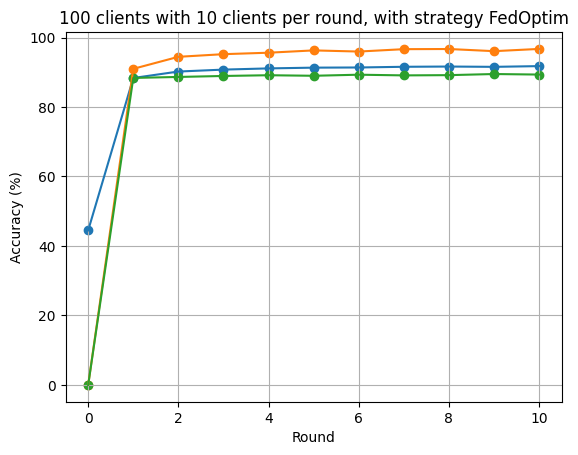

╒═════════╤════════════════╤═════════════╤══════════╕
│   Round │   Accuracy (%) │   Precision │   Recall │
╞═════════╪════════════════╪═════════════╪══════════╡
│       0 │        44.4993 │      0      │   0      │
├─────────┼────────────────┼─────────────┼──────────┤
│       1 │        88.3444 │     88.362  │  90.9824 │
├─────────┼────────────────┼─────────────┼──────────┤
│       2 │        90.2031 │     88.6482 │  94.4418 │
├─────────┼────────────────┼─────────────┼──────────┤
│       3 │        90.7593 │     88.9283 │  95.2032 │
├─────────┼────────────────┼─────────────┼──────────┤
│       4 │        91.1057 │     89.1416 │  95.6222 │
├─────────┼────────────────┼─────────────┼──────────┤
│       5 │        91.3244 │     88.9837 │  96.2892 │
├─────────┼────────────────┼─────────────┼──────────┤
│       6 │        91.3709 │     89.2938 │  95.9575 │
├─────────┼────────────────┼─────────────┼──────────┤
│       7 │        91.5718 │     89.0957 │  96.6422 │
├─────────┼────────────────┼

In [70]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# I dati dell'accuratezza
print(f"{history.metrics_centralized = }")
global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_recall_centralised = history.metrics_centralized["recall"]
global_precision_centralised = history.metrics_centralized["precision"]


rounds = [data[0] for data in global_accuracy_centralised]
accuracies = [100.0 * data[1] for data in global_accuracy_centralised]
recalls = [100.0 * data[1] for data in global_recall_centralised]
precisions = [100.0 * data[1] for data in global_precision_centralised]


# Plot
plt.plot(rounds, accuracies)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.scatter(rounds,accuracies)

plt.plot(rounds,recalls)
plt.scatter(rounds,recalls)

plt.plot(rounds,precisions)
plt.scatter(rounds,precisions)


plt.title(str(settings['NUM_CLIENTS']) + ' clients with ' + str(int(settings['FRACTION_FIT']*settings['NUM_CLIENTS'])) + ' clients per round, with strategy ' + settings['STRATEGY_TYPE'])  # Correzione qui
plt.show()

# Tabella
data_table = [["Round", "Accuracy (%)","Precision","Recall"]] + [[r, a,p,rec] for r, a,p, rec in zip(rounds, accuracies, precisions, recalls)]
table = tabulate(data_table, headers="firstrow", tablefmt="fancy_grid")
print(table)